# Face Detection using Convolutional Neural Networks

## Project Overview
This project aims to build a binary image classifier that detects whether an image contains a human face or not, using a Convolutional Neural Network (CNN) implemented in PyTorch. The system is trained on a labeled dataset of face and non-face images and includes data preprocessing, model training, validation, and evaluation components. The project serves as a foundational computer vision task applicable to surveillance, authentication systems, and real-time detection tools.

### Key Steps
1. **Data Preprocessing:**
    - All input images are resized to **48x48 pixels** and converted to PyTorch tensors.
    - **Data augmentation** techniques such as random horizontal flipping and rotation are applied to improve model robustness.
    - The dataset is divided into **Training** , **Validation** , and **Testing** sets.
2. **Model Architecture:**
    - A custom **CNN** is constructed using stacked convolutional layers, **ReLU activations** , and **max pooling** operations.
    - A **dropout layer** is added to the fully connected portion of the network to mitigate overfitting.
    - The final layer uses a **Sigmoid activation function** for binary classification between face and non-face classes.
3. **Training:**
    - The model is trained using **Binary Cross-Entropy Loss** , optimized via the **Adam optimizer**.
    - Losses are tracked separately for training and validation datasets over 50 epochs.
    - **Checkpointing** is used to save the model with the best validation performance.
4. **Evaluation Metrics:**
    - The final model is evaluated using the **accuracy score** and a **confusion matrix**.
    - A **heatmap** is generated to visualize the confusion matrix and interpret class-wise performance.
5. **Result Visualization:**
    - **Loss curves** are plotted to visualize the learning process over training epochs.
    - Predictions on test data are used to assess classification quality and potential model limitations.

### Model Summary
- A lightweight and effective CNN-based classifier was built to differentiate between face and non-face images.
- The model achieved satisfactory performance on unseen data, showcasing its ability to generalize.
- Key features such as data augmentation, dropout regularization, and validation monitoring were incorporated to enhance training stability and prevent overfitting.

### Future Work
- **Model Upgrade** : Integrate more advanced architectures like **ResNet** or **EfficientNet** for improved accuracy.
- **Data Scaling** : Train on a larger, more diverse dataset to improve performance in real-world scenarios.
- **Augmentation Enhancements** : Apply more varied augmentation techniques for better generalization.
- **Real-Time Application** : Deploy the model into a **live camera feed** or web application for practical use.
- **Model Explainability** : Implement tools such as **Grad-CAM** to visualize model decision areas on input images.

### Step 1: Import Required Libraries
To begin, we import all the necessary libraries. This includes PyTorch for model development and training, torchvision for data transformations, and PIL for image loading. Additionally, we use Seaborn and Matplotlib for data visualization, and Scikit-learn to compute accuracy and the
confusion matrix for evaluation.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

### Step 2: Define Hyperparameters and Device
Here, we define key hyperparameters for our training process, including the image size, batch size, number of epochs, and learning rate. We also configure the device, using a GPU if available to accelerate training; otherwise, the model will run on the CPU.

In [2]:
# Hyperparameters
IMG_SIZE = 48
BATCH_SIZE = 32
EPOCHS = 50
LR = 0.001

In [3]:
# Select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Step 3: Define Image Transformations
In this step, we define the transformations to apply to each image in the dataset. Images are resized to 48x48 pixels, and random horizontal flips and rotations are used to augment the dataset, improving model generalization. Finally, the images are converted into tensors, making them
compatible with PyTorch models.

In [4]:
# Transformations for data
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

### Step 4: Create Custom Dataset Loader
In this step, a custom dataset loader is created to handle face and non-face images. The dataset loader takes the directories of face and non-face images as input, assigns labels (1 for faces, 0 for non-faces), and applies the previously defined transformations. This loader ensures that each image is returned along with its corresponding label during training or evaluation.

In [5]:
# Dataset loader
class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, face_dir, non_face_dir, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform

        for img in os.listdir(face_dir):
            self.images.append((os.path.join(face_dir, img), 1))  # Label 1 for faces
        for img in os.listdir(non_face_dir):
            self.images.append((os.path.join(non_face_dir, img), 0))  # Label 0 for non-faces

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path, label = self.images[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

### Step 5: Define CNN Model
This step involves designing the CNN model architecture. The model consists of two convolutional layers followed by max pooling, which helps reduce the image dimensions. The output is then flattened and passed through fully connected layers. A dropout layer is included for regularization, and the final layer uses a Sigmoid activation function to predict probabilities for binary classification (face or non-face).

In [6]:
# CNN model for face detection
class FaceDetectorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1), nn.Sigmoid()
        )


    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

### Step 6: Load Training, Validation, and Test Data
The datasets for training, validation, and testing are loaded using the custom dataset loader. This step involves preparing the data for training, validation, and testing, making use of the DataLoader class to batch the data and shuffle it during training. This ensures that the model is trained efficiently and generalizes well to unseen data.

In [7]:
# Load datasets
train_faces_dir = 'train/faces'
train_non_faces_dir = 'train/non-faces'
test_faces_dir = 'test/faces'
test_non_faces_dir = 'test/non-faces'
val_faces_dir = 'val/faces'
val_non_faces_dir = 'val/non-faces'

train_dataset = FaceDataset(train_faces_dir, train_non_faces_dir, transform)
test_dataset = FaceDataset(test_faces_dir, test_non_faces_dir, transform)
val_dataset = FaceDataset(val_faces_dir, val_non_faces_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

### Step 7: Define Training Loop
The training loop is defined in this step. During each epoch, the model is trained on the training data and evaluated on the validation data. The model’s performance is monitored by tracking the loss for both training and validation. The best-performing model, based on validation loss, is saved during training to prevent overfitting.

In [8]:
# Training Loop
def train_model(model, train_loader, val_loader, epochs, lr, save_path='best_model.pth'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')  # Initialize to a high value

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1).float()  # Ensure float labels

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ---- Validation ----
        model.eval()
        epoch_val_loss = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device).unsqueeze(1).float()

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # ---- Checkpointing ----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✔️ Saved new best model (val loss: {avg_val_loss:.4f})")

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

### Step 8: Define Evaluation Function
The evaluation function is used to assess the model’s performance on the test dataset after training. The model’s predictions are compared with the true labels, and metrics such as accuracy and confusion matrix are calculated. This function also visualizes the confusion matrix to provide insight into how well the model is distinguishing between faces and non-faces.

In [9]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images).cpu().numpy()
            preds = (outputs > 0.5).astype(int).flatten()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n✅ Test Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Face", "Face"], yticklabels=["Non-Face", "Face"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Accuracy: {acc:.2%})")
    plt.tight_layout()
    plt.show()

    return acc, cm

### Step 9: Train the Model and Save
In this step, the CNN model is instantiated and trained using the previously defined training loop. The best-performing model, based on validation loss, is saved to a file. The trained model can later be loaded for inference or further fine-tuning.

In [10]:
# Run training
model = FaceDetectorCNN()
train_losses, val_losses = train_model(
    model,
    train_loader,  # Training data loader
    val_loader,    # Validation data loader
    epochs=EPOCHS,  # Number of epochs
    lr=LR,          # Learning rate
    save_path='best_model.pth'  # Path to save the best model
)

c:\Users\durus\miniconda3\envs\ee655\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


✔️ Saved new best model (val loss: 0.5146)
Epoch 1/50 | Train Loss: 0.3707 | Val Loss: 0.5146
✔️ Saved new best model (val loss: 0.4589)
Epoch 2/50 | Train Loss: 0.2122 | Val Loss: 0.4589
Epoch 3/50 | Train Loss: 0.1769 | Val Loss: 0.7556
Epoch 4/50 | Train Loss: 0.1608 | Val Loss: 0.5973
Epoch 5/50 | Train Loss: 0.1410 | Val Loss: 0.5170
Epoch 6/50 | Train Loss: 0.1315 | Val Loss: 0.4999
Epoch 7/50 | Train Loss: 0.1223 | Val Loss: 0.5717
Epoch 8/50 | Train Loss: 0.1021 | Val Loss: 0.6974
✔️ Saved new best model (val loss: 0.4354)
Epoch 9/50 | Train Loss: 0.1067 | Val Loss: 0.4354
Epoch 10/50 | Train Loss: 0.0984 | Val Loss: 0.4620
Epoch 11/50 | Train Loss: 0.0917 | Val Loss: 0.4449
Epoch 12/50 | Train Loss: 0.0931 | Val Loss: 0.4417
Epoch 13/50 | Train Loss: 0.0815 | Val Loss: 0.4946
Epoch 14/50 | Train Loss: 0.0799 | Val Loss: 0.5119
Epoch 15/50 | Train Loss: 0.0749 | Val Loss: 0.5626
Epoch 16/50 | Train Loss: 0.0723 | Val Loss: 0.6020
Epoch 17/50 | Train Loss: 0.0770 | Val Loss: 0.6

In [11]:
# Save model
torch.save(model.state_dict(), 'face_detector_trained3.pth')

### Step 10: Evaluate the Model
After training, the model is evaluated on the test dataset to assess how well it generalizes to unseen data. This is done by computing the accuracy and displaying the confusion matrix, which provides a deeper understanding of the model’s performance.


✅ Test Accuracy: 0.9008
Confusion Matrix:
[[1263  241]
 [  69 1553]]


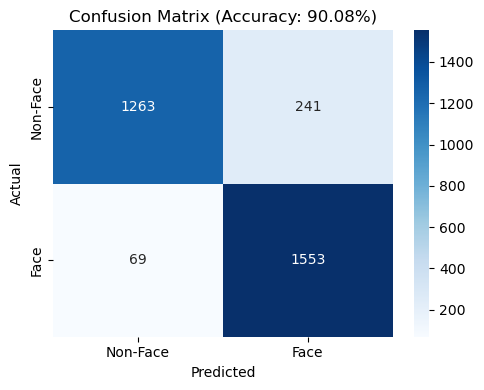

(0.9008317338451696,
 array([[1263,  241],
        [  69, 1553]], dtype=int64))

In [12]:
# Run evaluation
evaluate_model(model, test_loader)

### Step 11: Plot Loss Curves
The loss curves for training and validation are plotted to visualize the model’s learning process over the epochs. This helps to identify potential issues such as overfitting or underfitting. By comparing the training and validation loss curves, we can gain insights into the stability of the training process.

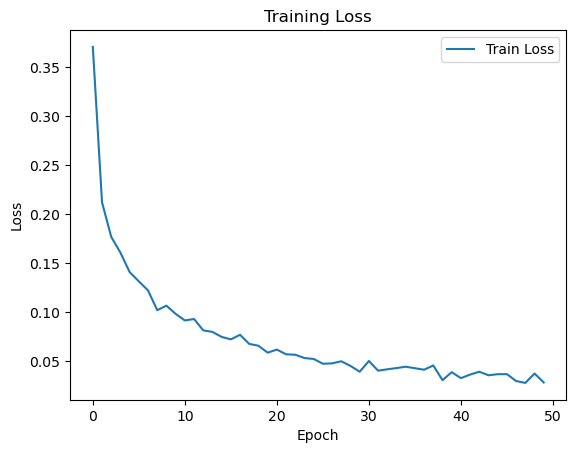

In [13]:
# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.show()

### Conclusion
In this project, we successfully built a CNN model from scratch using PyTorch for face detection. We utilized a custom dataset loader, applied data augmentation to improve generalization, and evaluated the model using metrics such as accuracy and confusion matrix. The results were visualized through loss curves and the confusion matrix, providing a comprehensive view of the model’s performance.